In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [36]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 51.14%
Test size ≃ 48.86%


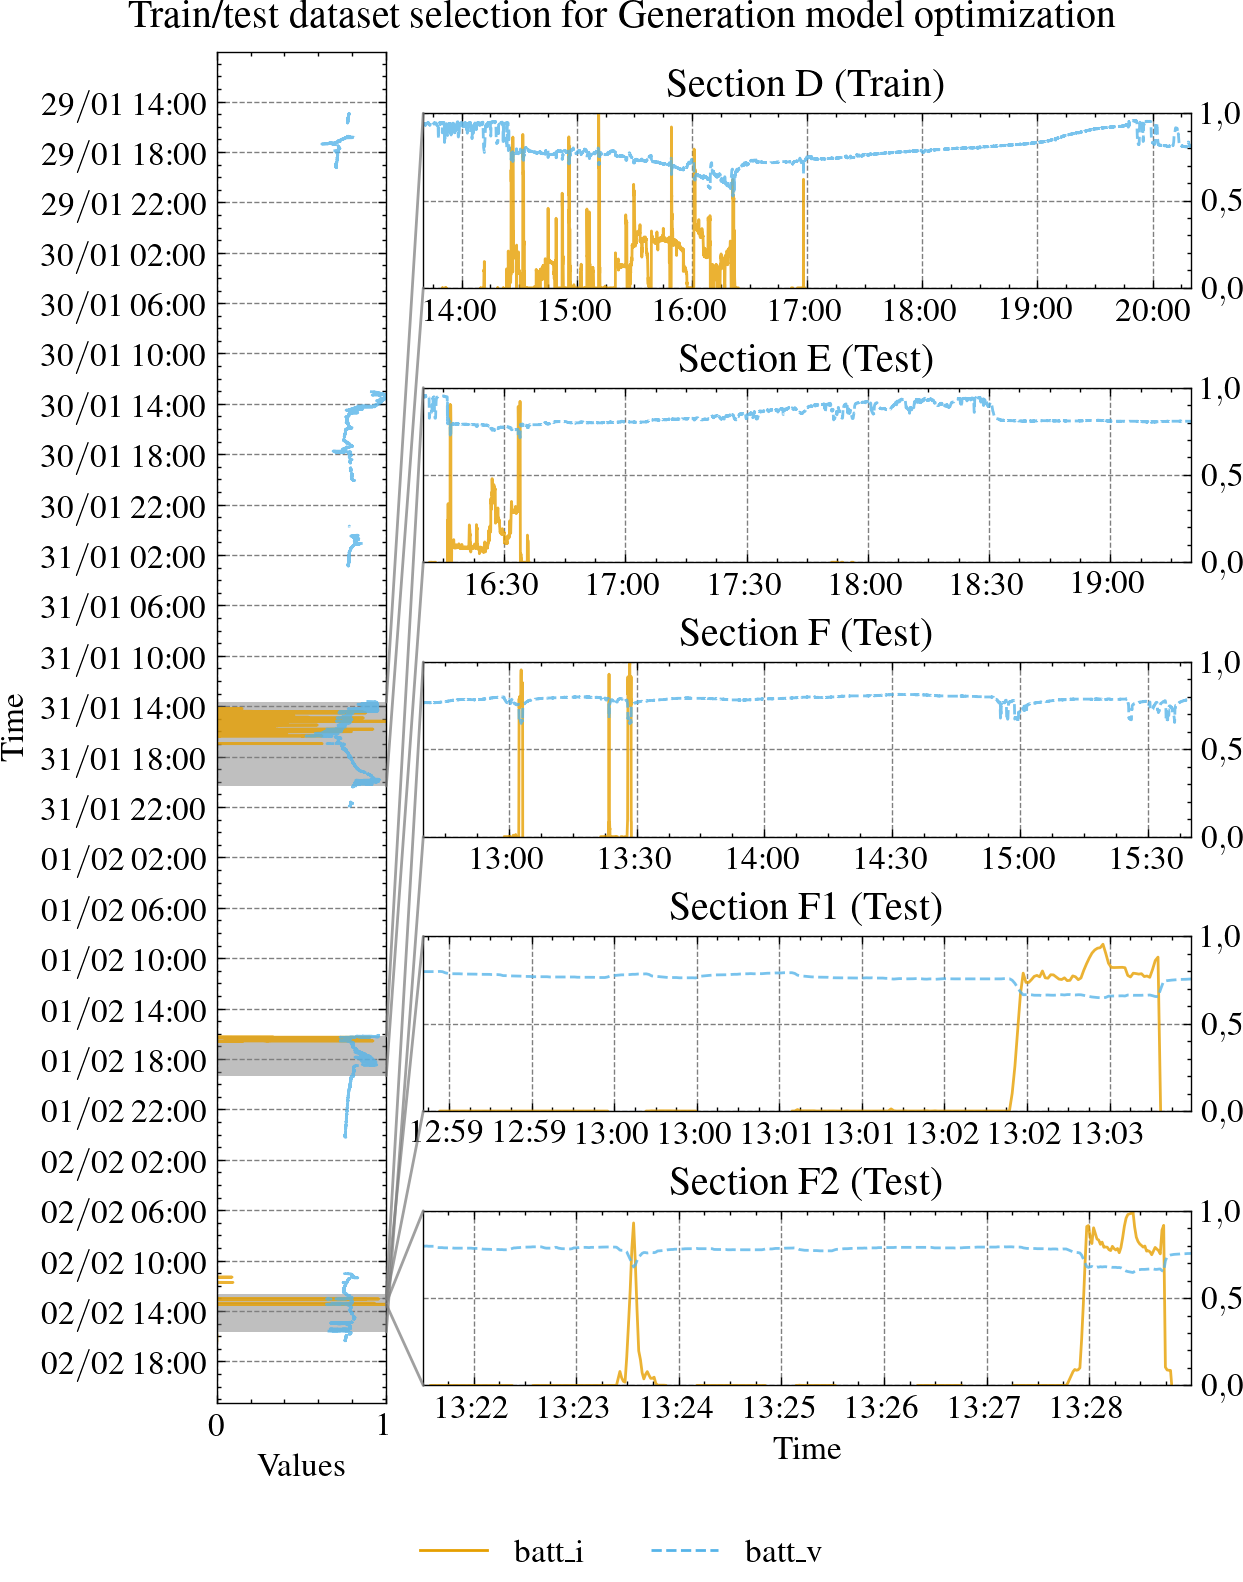

In [ ]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


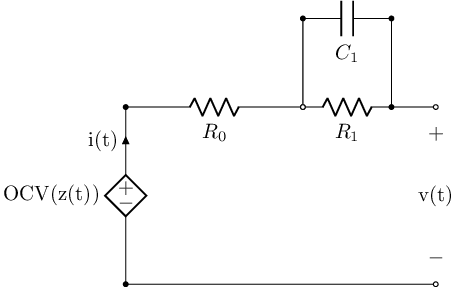

In [134]:
# %pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [135]:
import control as ct

def eval_poly(coeffs, x):
    result = 0.0
    for c in reversed(coeffs[1:]):
        result = (result + c) * x
    return result + coeffs[0]

class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1_coeffs = params['batt_R_1_coeffs']

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Interpolate parameters
        batt_R_1 = eval_poly(batt_R_1_coeffs, batt_z_0)

        # Initial condition equations
        batt_v_C_1_0 = batt_i_0 * batt_R_1

        return np.array([batt_z_0, batt_v_C_1_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta = params['batt_eta']
        batt_Q = params['batt_Q']
        batt_R_1_coeffs = params['batt_R_1_coeffs']
        batt_C_1_coeffs = params['batt_C_1_coeffs']

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]

        # Interpolate parameters
        batt_R_1 = eval_poly(batt_R_1_coeffs, batt_z)
        batt_C_1 = eval_poly(batt_C_1_coeffs, batt_z)

        # System of differential equations
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_R_1 * batt_C_1)) + (batt_i / batt_C_1)

        return np.array([d_batt_z, d_batt_v_C_1])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_N_S = params['batt_N_S']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0_coeffs = params['batt_R_0_coeffs']

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]

        # Interpolate parameters
        batt_R_0 = eval_poly(batt_R_0_coeffs, batt_z)

        # Output equations
        batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)
        batt_v = batt_N_S*(batt_ocv - batt_v_C_1 - batt_R_0 * batt_i)

        return np.array([batt_v, batt_z, batt_ocv])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'batt_v_C_1'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem:battery:['batt_i']->['batt_v', 'batt_z', 'batt_ocv']>

array([  10.50077129,   11.70306904,  -47.97673888,  120.12010661,
       -163.22052539,  113.26357466,  -31.29084967])

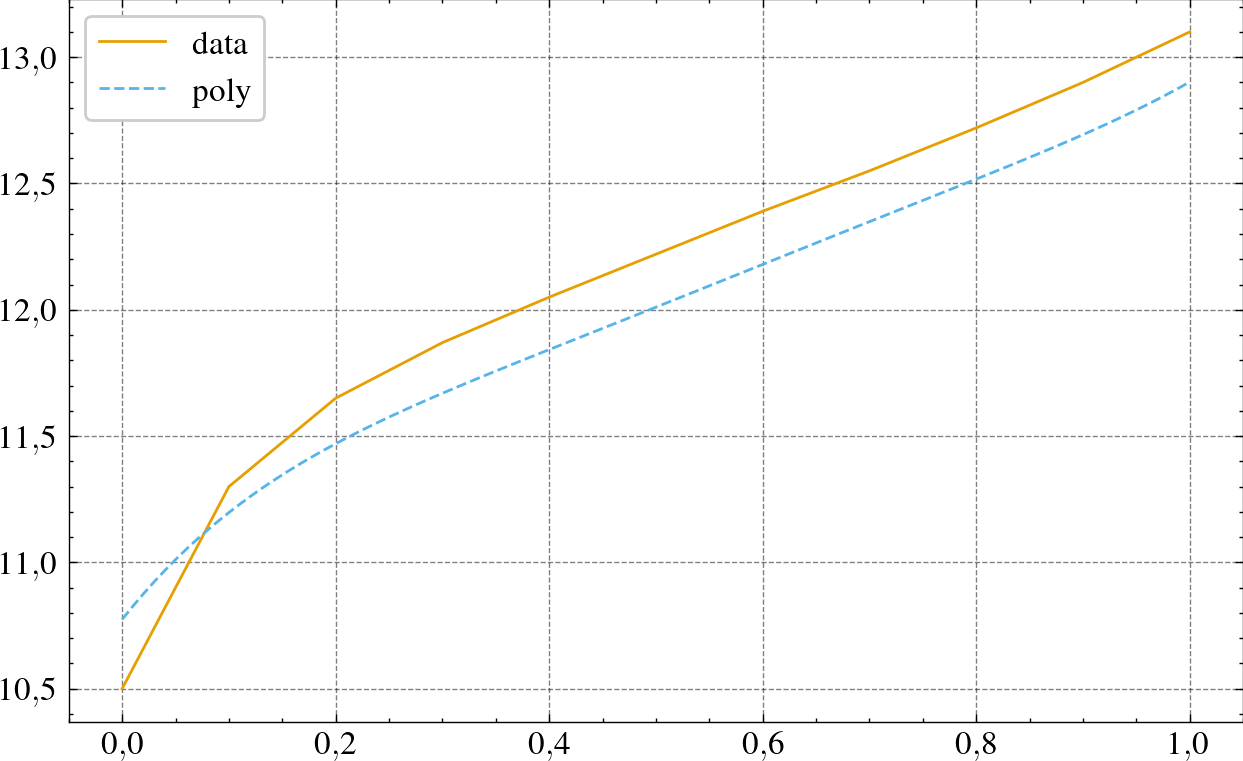

In [136]:
plt.figure()

# From: https://imgv2-2-f.scribdassets.com/img/document/682244176/original/0a169c4659/1730632177?v=1
ocv = np.array([13.1, 12.9, 12.72, 12.55, 12.39, 12.22, 12.05, 11.87, 11.65, 11.3, 10.5])[::-1]
soc = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])[::-1]
plt.plot(soc, ocv, label='data')

soc_test = np.linspace(0, 1, 100)

deg = 6
batt_k_V_OC_coeffs = np.polynomial.Polynomial.fit(soc, ocv, deg, domain=[0, 1], window=[0, 1]).coef
display(batt_k_V_OC_coeffs)

batt_k_V_OC_coeffs = np.array([10.77420498818087, 5.342402189767365, -13.256712152302418, 23.44686407251436, -20.24985001372384, 6.845076498059946])

ocv_poly = eval_poly(batt_k_V_OC_coeffs, soc_test)
# or: ocv_poly = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(soc_test)
plt.plot(soc_test, ocv_poly, label='poly')
plt.legend()
plt.show()

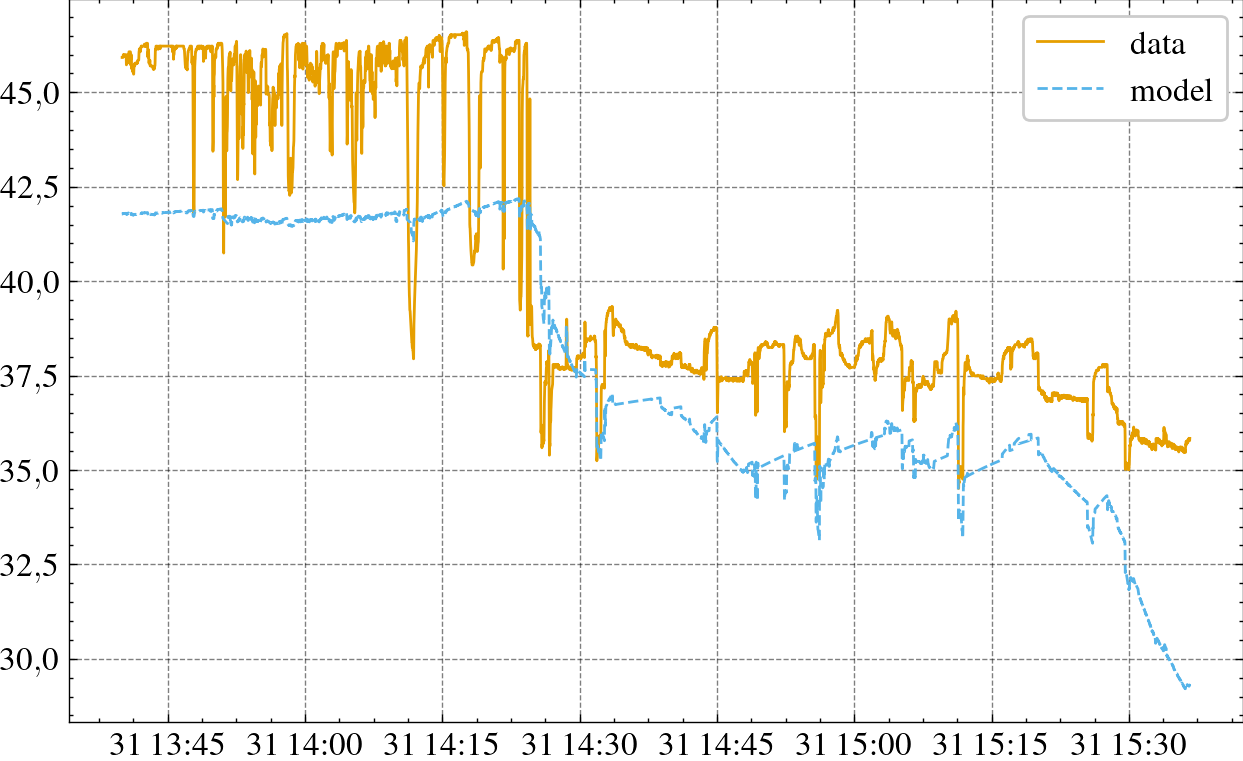

In [137]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage

battery_params = {
    'batt_N_S': series_cells,
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
    'batt_R_0_coeffs': [0.005],
    'batt_R_1_coeffs': [0.1],
    'batt_C_1_coeffs': [10000],
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:7000]

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.65}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

# Optimization

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
        # solve_ivp_kwargs=dict(max_step=1),
    ).to_pandas()

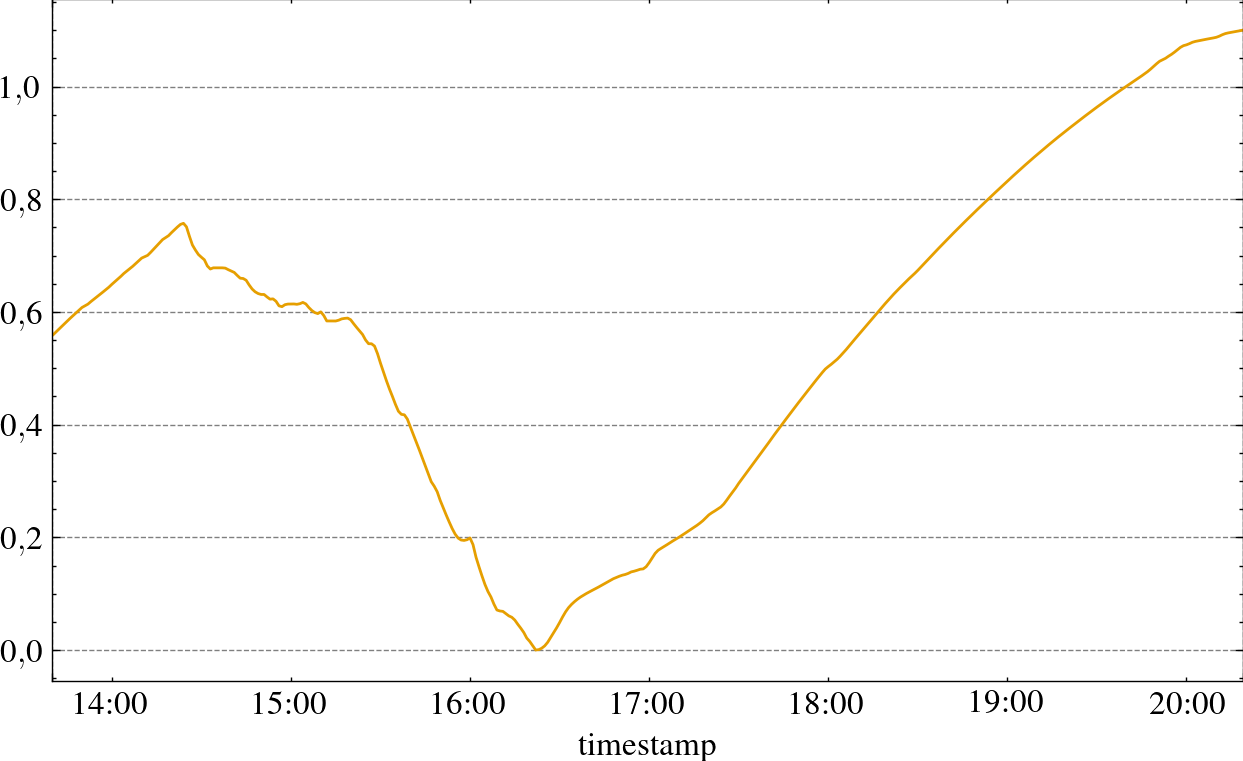

In [139]:
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()
df_train['batt_z'].plot()
plt.show()

In [140]:
# %%time

# import numpy as np
# from pymoo.core.problem import Problem
# from pymoo.optimize import minimize
# from pymoo.algorithms.soo.nonconvex.de import DE
# from pymoo.termination import get_termination
# from pymoo.core.variable import Real

# def run_battery_optimization(
#     df,
#     train_section,
#     nominal_Q,
#     battery_params,
#     model_function,
#     initial_SOC
# ):
#     """
#     Run the battery optimization with a hyperparameterized initial_SOC.
#     (Implementation as provided in your code snippet)
#     """
#     # Define optimization and input data columns
#     data_cols = ['batt_v']
#     input_cols = ['batt_i']

#     # Extract and resample training data
#     df_train = df.loc[
#         (df.index >= train_section['start']) & (df.index <= train_section['end']),
#         ['t'] + data_cols + input_cols
#     ].resample('1min').mean().interpolate(method='time')

#     # Compute battery capacity and SOC using the hyperparameter initial_SOC
#     compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
#     compute_df_soc(df_train, nominal_Q, inplace=True)
#     # Optionally adjust batt_z (if needed)
#     # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

#     # Set model state initial conditions
#     batt_z_0 = df_train['batt_z'].iloc[0]
#     input_initial_state = {'batt_z': batt_z_0}

#     # Initialize parameter bounds for the optimization
#     params_bounds = {}
#     poly_coeffs = [
#         # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 2, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
#         {'name': 'batt_R_0_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 1)},
#         {'name': 'batt_R_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 1)},
#         {'name': 'batt_C_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1, 1e6)},
#     ]
#     for coeff in poly_coeffs:
#         name = coeff['name']
#         n_coeffs = coeff['n_coeffs']
#         y_bounds = coeff['y_bounds']
#         coeff_bounds = estimate_polynomial_coefficient_bounds(
#             x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
#         )
#         for i in range(n_coeffs):
#             params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

#     # Initialize the multiprocessing pool and parallel runner
#     from multiprocessing import Pool
#     n_processes = 32
#     pool = Pool(processes=n_processes)
#     runner = StarmapParallelization(pool.starmap)

#     # Define the battery model and parameters
#     model = Battery
#     model_params = battery_params.copy()

#     # Set up the optimization problem
#     problem = MyOptimizationProblem(
#         model=model,
#         model_function=model_function,
#         training_data=df_train,
#         training_data_columns=data_cols,
#         model_params=model_params,
#         opt_params_bounds=params_bounds,
#         input_initial_state=input_initial_state,
#         input_columns=input_cols,
#         data_scaler=MinMaxScaler,
#         elementwise_runner=runner,
#     )

#     # Configure the optimization algorithm (Differential Evolution)
#     algorithm = DE(
#         pop_size=10 * len(params_bounds),
#         sampling=LHS(),
#         variant="DE/rand/1/bin",
#         F=0.2,
#         CR=0.9,
#     )

#     # Set termination criteria
#     termination = DefaultSingleObjectiveTermination(
#         xtol=1e-8,
#         cvtol=1e-6,
#         ftol=1e-6,
#         period=20,
#         n_max_gen=1000,
#         n_max_evals=100000,
#     )

#     # Run the battery optimization
#     result = minimize(
#         problem,
#         algorithm,
#         termination=termination,
#         seed=42,
#         verbose=True,
#         save_history=True,
#     )

#     pool.close()
#     pool.join()

#     return result

# # --- Define the hyperparameter optimization problem for initial_SOC ---

# class BatteryHyperParameterProblem(Problem):
#     def __init__(self, df, train_section, nominal_Q, battery_params, model_function, **kwargs):
#         # One decision variable (initial_SOC) in [0, 1] and one objective.
#         super().__init__(n_var=1, n_obj=1, xl=np.array([0.0]), xu=np.array([1.0]), type_var=Real, **kwargs)
#         self.df = df
#         self.train_section = train_section
#         self.nominal_Q = nominal_Q
#         self.battery_params = battery_params
#         self.model_function = model_function

#     def _evaluate(self, X, out, *args, **kwargs):
#         # X is an array of shape (n_samples, 1), each row is an initial_SOC candidate.
#         f_vals = []
#         for x in X:
#             initial_SOC = x[0]
#             print(f"Evaluating for initial_SOC = {initial_SOC:.4f}")
#             result = run_battery_optimization(
#                 self.df,
#                 self.train_section,
#                 self.nominal_Q,
#                 self.battery_params,
#                 self.model_function,
#                 initial_SOC=initial_SOC
#             )
#             # Here we assume the battery optimization result has an attribute F that gives the objective value.
#             f_vals.append(result.F)
#         out["F"] = np.array(f_vals).reshape(-1, 1)

# # --- Set up and run the hyperparameter optimization ---

# # Instantiate the hyperparameter optimization problem.
# hyper_problem = BatteryHyperParameterProblem(
#     df=df,
#     train_section=train_section,
#     nominal_Q=nominal_Q,
#     battery_params=battery_params,
#     model_function=model_function,
# )

# # Configure the DE algorithm for the hyperparameter search.
# algorithm_hyper = DE(
#     pop_size=10,
#     variant="DE/rand/1/bin",
#     F=0.5,
#     CR=0.9,
# )
# # algorithm_hyper = NelderMead()

# # Define a termination criterion, e.g., 10 generations.
# # termination_hyper = get_termination("n_gen", 10)
# termination_hyper = DefaultSingleObjectiveTermination(
#     xtol=1e-8,
#     cvtol=1e-6,
#     ftol=1e-6,
#     period=10,
#     n_max_gen=1000,
#     n_max_evals=100000,
# )

# # Run the hyperparameter optimization.
# result_hyper = minimize(
#     hyper_problem,
#     algorithm_hyper,
#     termination=termination_hyper,
#     seed=42,
#     verbose=True,
# )

# print("Best initial_SOC found:", result_hyper.X)
# print("Objective value at best initial_SOC:", result_hyper.F)

# initial_SOC = result_hyper.X

In [141]:
initial_SOC = np.array([0.7])

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  0.0090961635 |  0.0066380374
     2 |       60 |  0.0084238984 |  0.0064523675
     3 |       90 |  0.0077716399 |  0.0064523675
     4 |      120 |  0.0071557260 |  0.0064523675
     5 |      150 |  0.0069110767 |  0.0064523675
     6 |      180 |  0.0067845711 |  0.0063150236
     7 |      210 |  0.0066720174 |  0.0063150236
     8 |      240 |  0.0065764360 |  0.0062144808
     9 |      270 |  0.0064604026 |  0.0061781990
    10 |      300 |  0.0064110025 |  0.0061781990
    11 |      330 |  0.0063674381 |  0.0061781990
    12 |      360 |  0.0063233831 |  0.0061781990
    13 |      390 |  0.0062759704 |  0.0061545024
    14 |      420 |  0.0062539718 |  0.0061545024
    15 |      450 |  0.0062350965 |  0.0061545024
    16 |      480 |  0.0062203403 |  0.0061545024
    17 |      510 |  0.0062153550 |  0.0061545024
    18 |      540 |  0.0062060905 |  0.0061545024
    19 |      570 |  0.0062032749 |  0.0061545024


{'batt_C_1_coeffs': [10000],
 'batt_R_1_coeffs': [0.1],
 'batt_R_0_coeffs': [0.005]}

Best parameters found:


{'batt_C_1_coeffs': [81027.77846453393],
 'batt_R_1_coeffs': [0.04992665720211692],
 'batt_R_0_coeffs': [0.004989484239046979]}

Objective value at solution: [0.00609426]


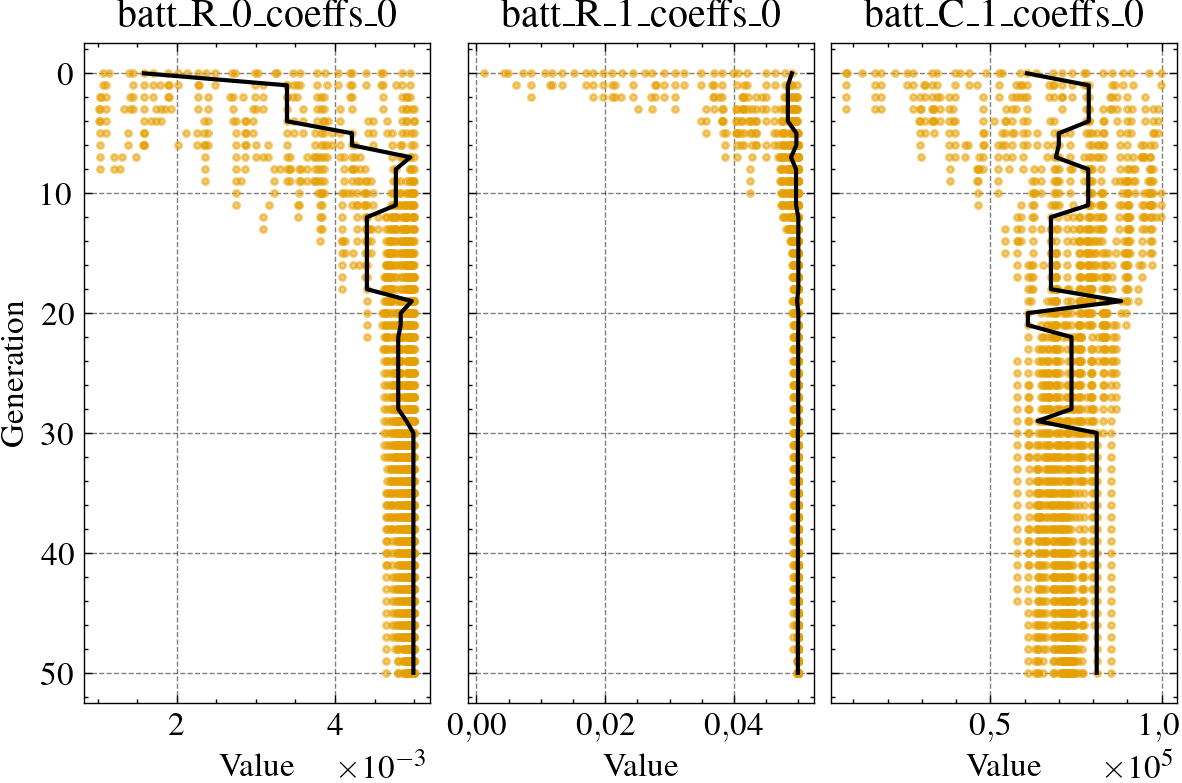

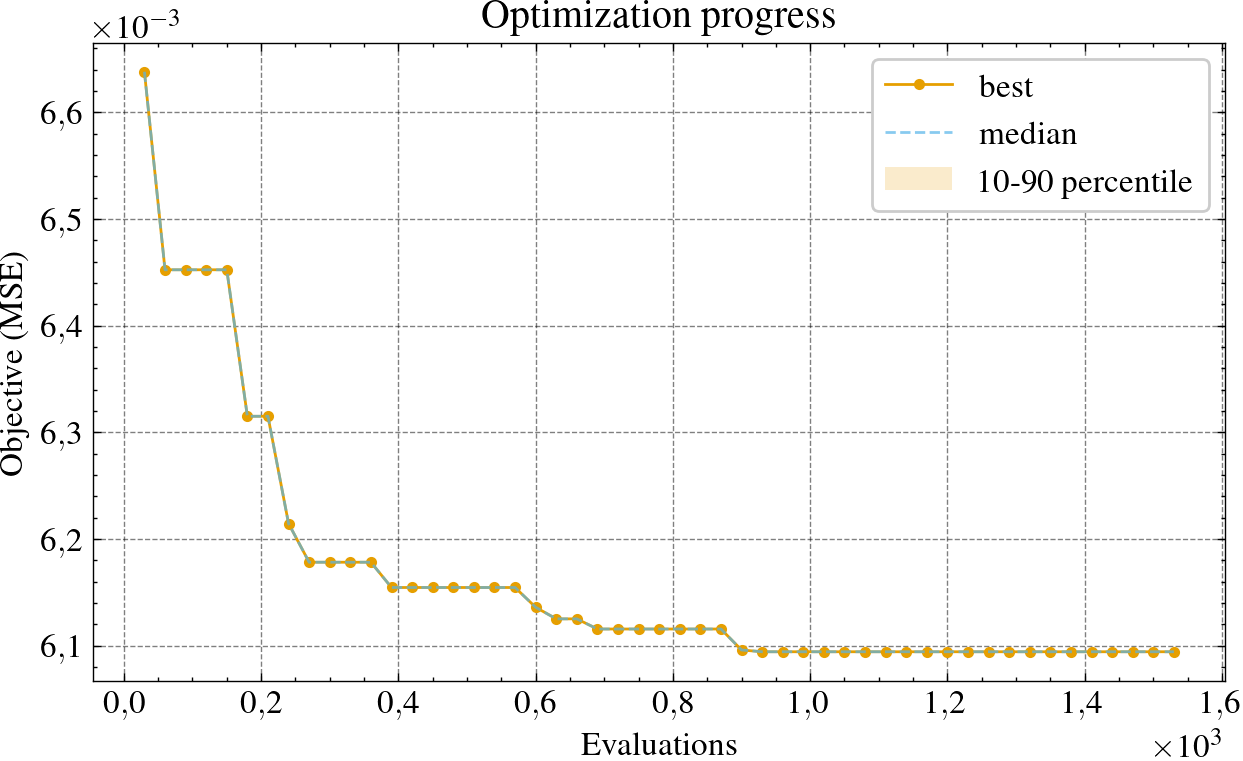

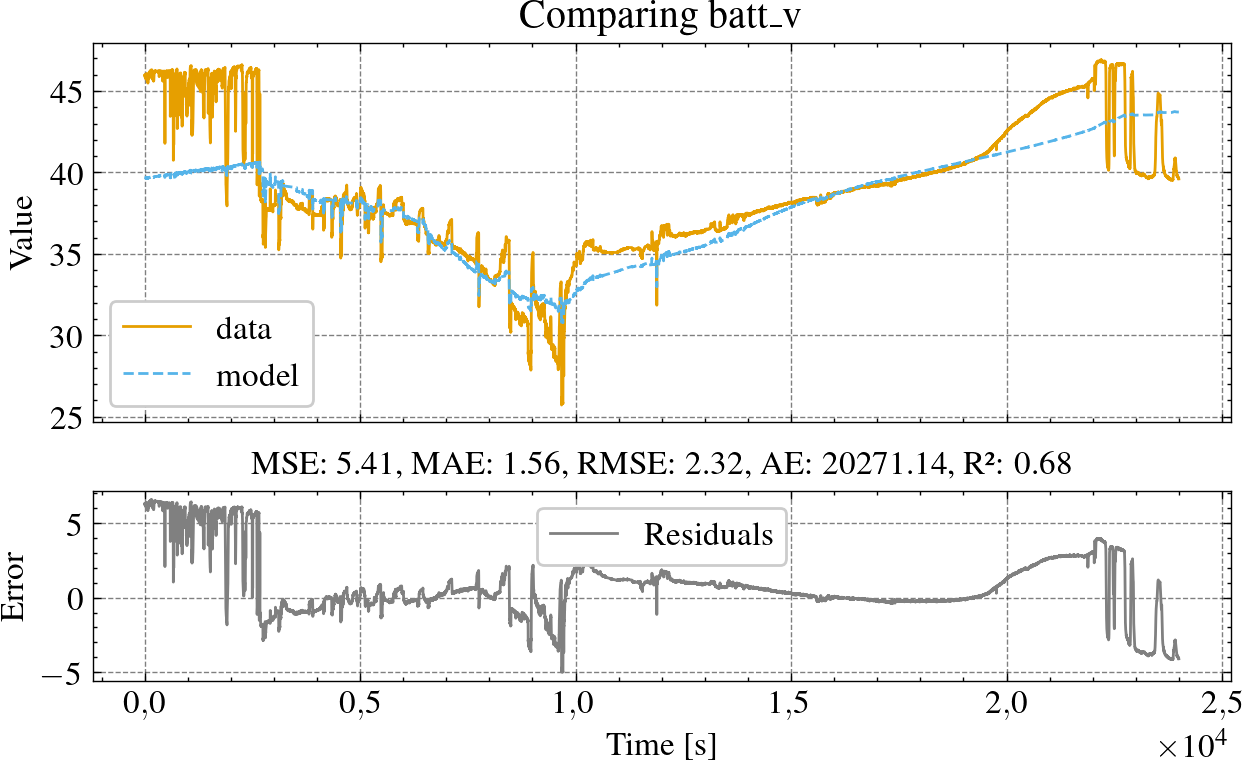

CPU times: user 2.4 s, sys: 2.71 s, total: 5.11 s
Wall time: 31.9 s


In [ ]:
%%time

def run_battery_optimization(
    df,
    train_section,
    nominal_Q,
    model,
    model_params,
    model_function,
    initial_SOC
):
    """
    Run the battery optimization with a hyperparameterized initial_SOC.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the simulation data.
    train_section : dict
        Dictionary with 'start' and 'end' keys for slicing the training data.
    nominal_Q : float
        Nominal battery capacity.
    model_params : dict
        Dictionary of initial battery parameters.
    model_function : callable
        The battery model function used in the optimization.
    initial_SOC : float
        The initial state of charge, treated as a hyperparameter.

    Returns
    -------
    result : optimization result object
        The result returned by the optimization procedure.
    best_params : dict
        The best parameters found during optimization.
    """
    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

    # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')

    # Compute battery capacity and SOC using the hyperparameter initial_SOC
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)
    # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

    data_cols = ['batt_v', 'batt_z'] # Now we have batt_z

    # Set model state initial conditions
    input_initial_state = {
        'batt_z': df_train['batt_z'].iloc[0]
    }

    # Initialize parameter bounds for the optimization
    params_bounds = {}
    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
        {'name': 'batt_R_0_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 5e-3)},
        {'name': 'batt_R_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 5e-2)},
        {'name': 'batt_C_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (5e3, 1e5)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    # Set up the optimization problem
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    # Configure the optimization algorithm (Differential Evolution in this case)
    algorithm = DE(
        pop_size=10 * len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Set termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000,
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )

    pool.close()
    pool.join()

    return result, params_bounds

model = Battery
model_params = battery_params.copy()
result, params_bounds = run_battery_optimization(
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    model=model,
    model_params=model_params,
    model_function=model_function,
    initial_SOC=initial_SOC
)

# Retrieve and display the best parameters
best_params = convert_to_model_params({k: result.X[i] for i, k in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

# Plot optimization results
plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

# Simulate the model with the optimized parameters
df_train = df.loc[
    (df.index >= train_section['start']) & (df.index <= train_section['end']),
    ['t'] + data_cols + input_cols
].resample('1s').mean().interpolate(method='time')
T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = Battery.initial_state(
    X0={'batt_z': initial_SOC[0]},
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

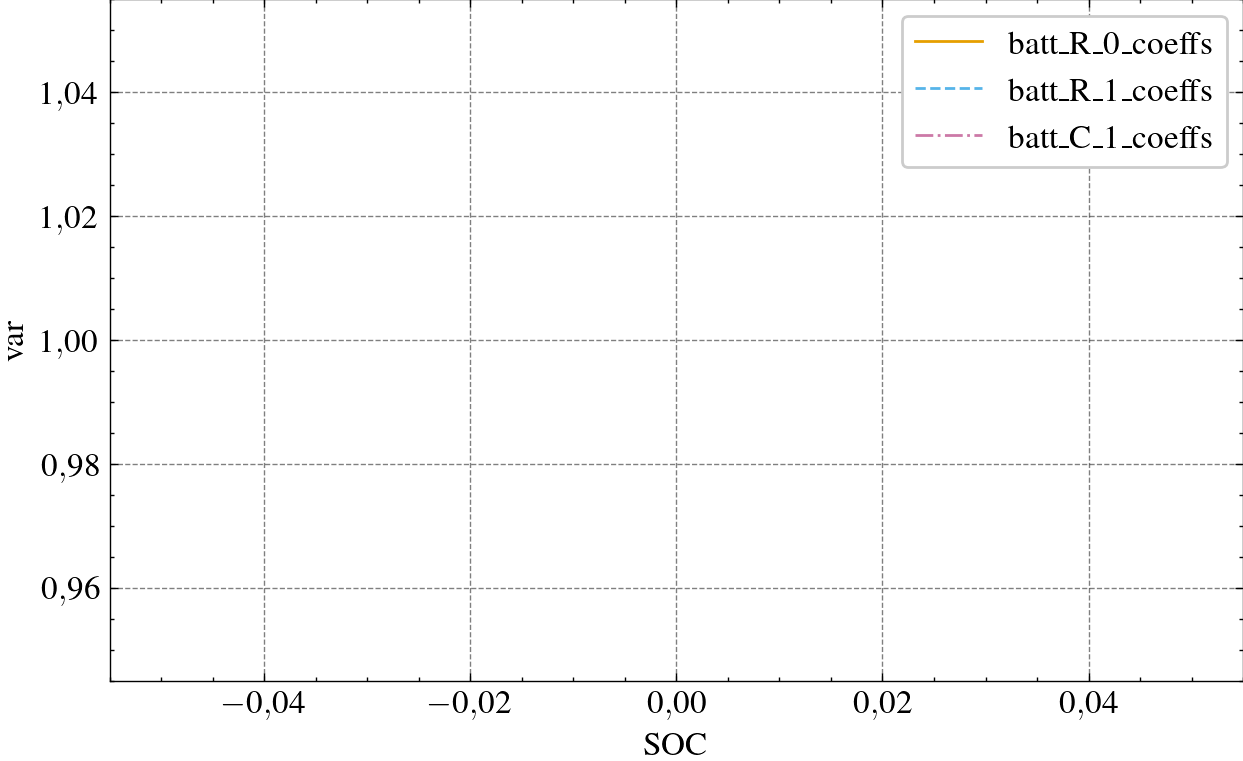

In [159]:
plt.figure()
plt.plot(best_params['batt_R_0_coeffs']/best_params['batt_R_0_coeffs'][0], label='batt_R_0_coeffs')
plt.plot(best_params['batt_R_1_coeffs']/best_params['batt_R_1_coeffs'][0], label='batt_R_1_coeffs')
plt.plot(best_params['batt_C_1_coeffs']/best_params['batt_C_1_coeffs'][0], label='batt_C_1_coeffs')
plt.ylabel('var')
plt.xlabel('SOC')
plt.legend()
plt.show()

In [160]:
if 'batt_k_V_OC_coeffs' in best_params:
    soc_test = np.linspace(0, 1, 100)
    batt_k_V_OC_coeffs = battery_params['batt_k_V_OC_coeffs']
    ocv_ref = eval_poly(batt_k_V_OC_coeffs, soc_test)
    plt.plot(soc_test, ocv_ref, label='original')

    best_ocv_coeffs = best_params['batt_k_V_OC_coeffs']
    ocv_pred = eval_poly(best_ocv_coeffs, soc_test)
    plt.plot(soc_test, ocv_pred, label='best')

    plt.legend()
    plt.show()


In [161]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, xl=np.array([0.0]), xu=np.array([1.0]), type_var=Real, **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].dropna().resample('1s').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = df_test['t'].to_numpy()
        U = df_test[self.input_cols].to_numpy().T

        X0 = Battery.initial_state(X0={'batt_z': df_test['batt_z'][0]}, U0=U[:, 0], params=self.model_params | self.best_params)
        df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

model_params = battery_params.copy()

# Run optimization for each section
batt_z_0_dict = {}
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    problem = BattZOptimization(
        section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=10,
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

    batt_z_0_dict[section_name] = res.X[0]

    print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

pool.close()
pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.206212E+01 |  5.3638166488
     2 |       20 |  1.225610E+01 |  5.3638166488
     3 |       30 |  8.2976259142 |  5.2157518606
     4 |       40 |  6.0663890444 |  5.1788903395
     5 |       50 |  5.4551603709 |  5.0688440406
     6 |       60 |  5.4099089071 |  5.0688440406
     7 |       70 |  5.2731072687 |  5.0688440406
     8 |       80 |  5.2395071845 |  5.0688440406
     9 |       90 |  5.1798136580 |  5.0688440406
    10 |      100 |  5.1752620599 |  5.0688440406
    11 |      110 |  5.1537620245 |  4.9700287404
    12 |      120 |  5.1323043378 |  4.9700287404
    13 |      130 |  5.1140114525 |  4.9700287404
    14 |      140 |  5.1140114525 |  4.9700287404
    15 |      150 |  5.1140114525 |  4.9700287404
    16 |      160 |  5.1116111871 |  4.9700287404
    17 |      170 |  5.1105822537 |  4.9700287404
    18 |      180 |  5.1105822537 |  4.9700287404
    19 |      190 |  5.1105822537 |  4.9700287404


{'D': 0.7865003040443304, 'E': 0.6919415213630293, 'F': 0.8192610834424398, 'F1': 0.580416143991433, 'F2': 0.7145301471370031}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


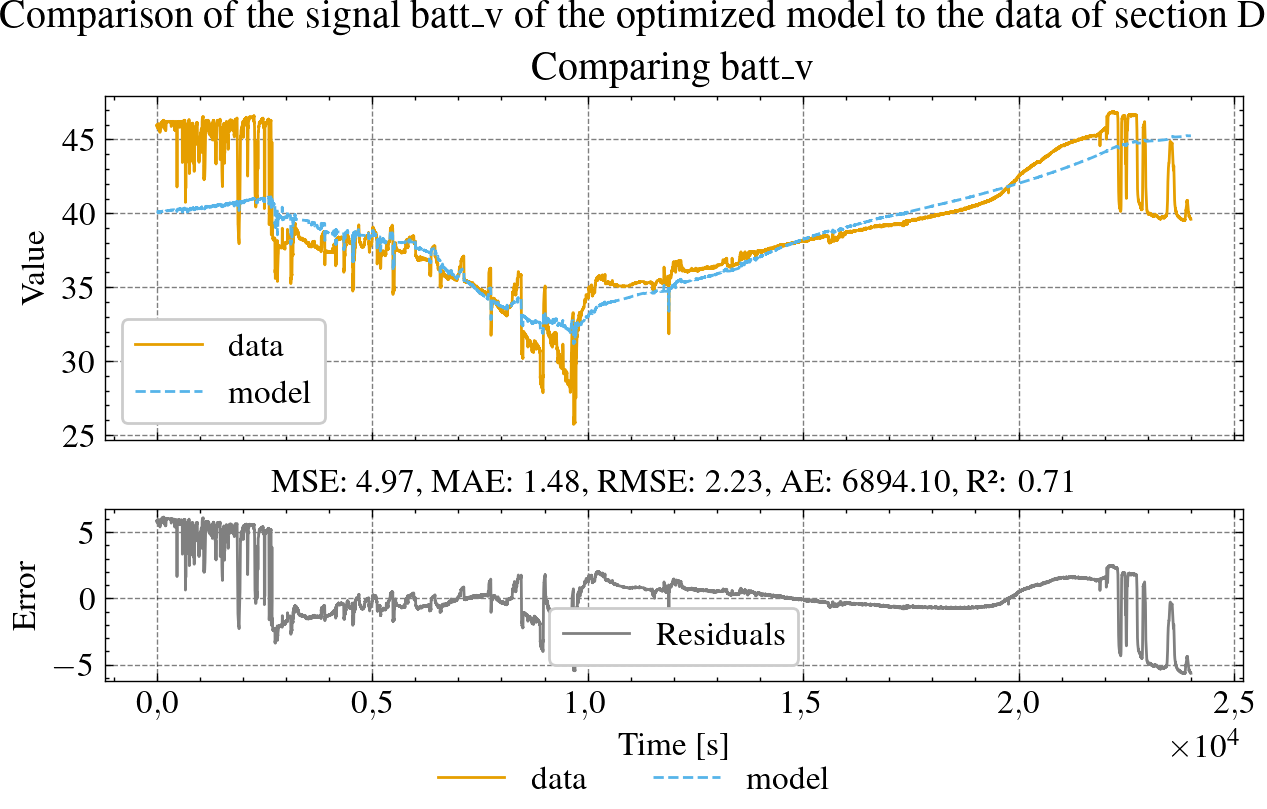

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_e.pdf


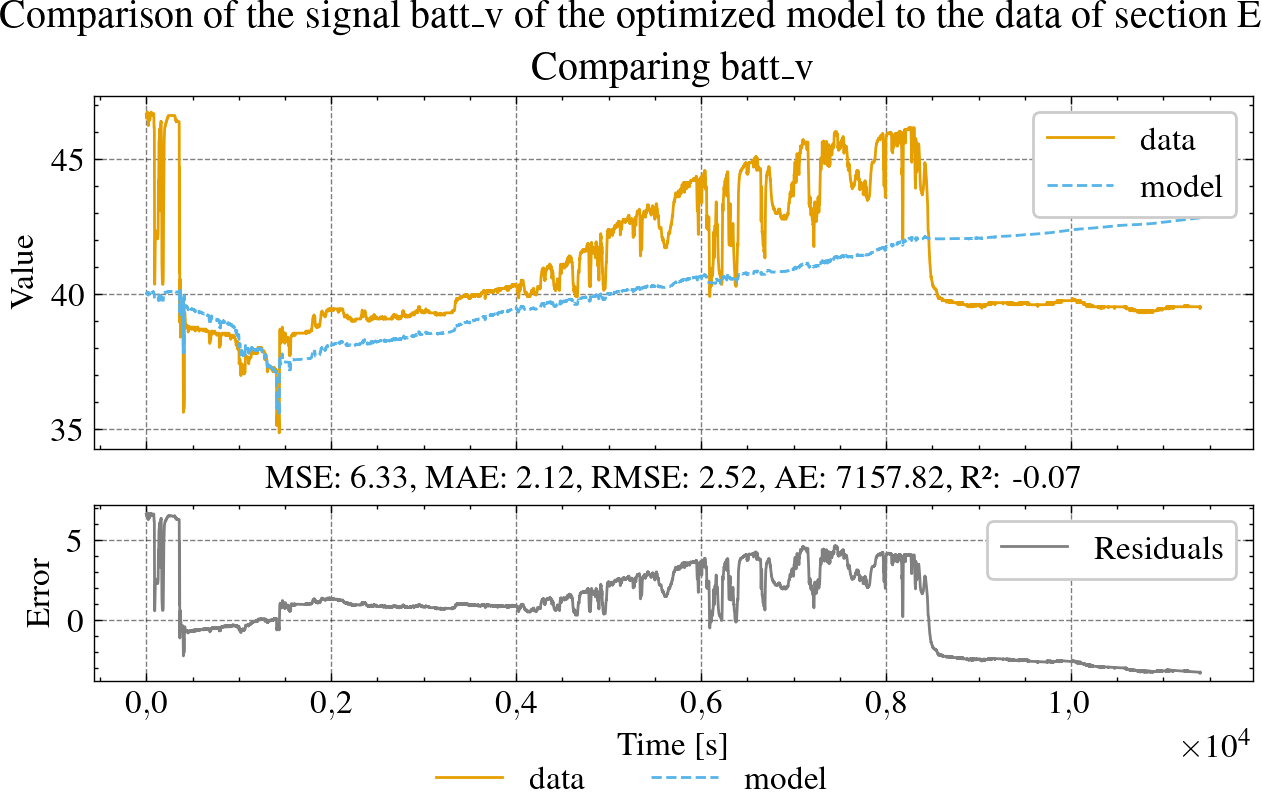

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f.pdf


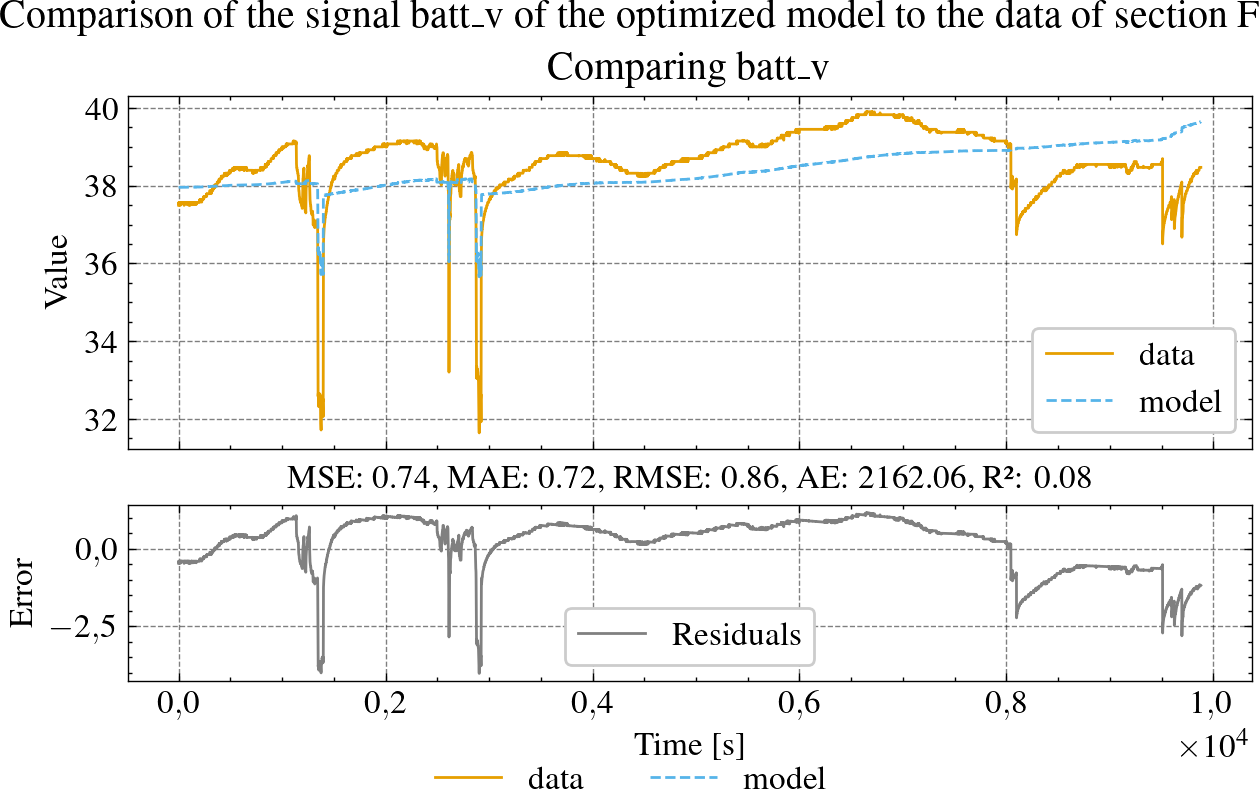

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f1.pdf


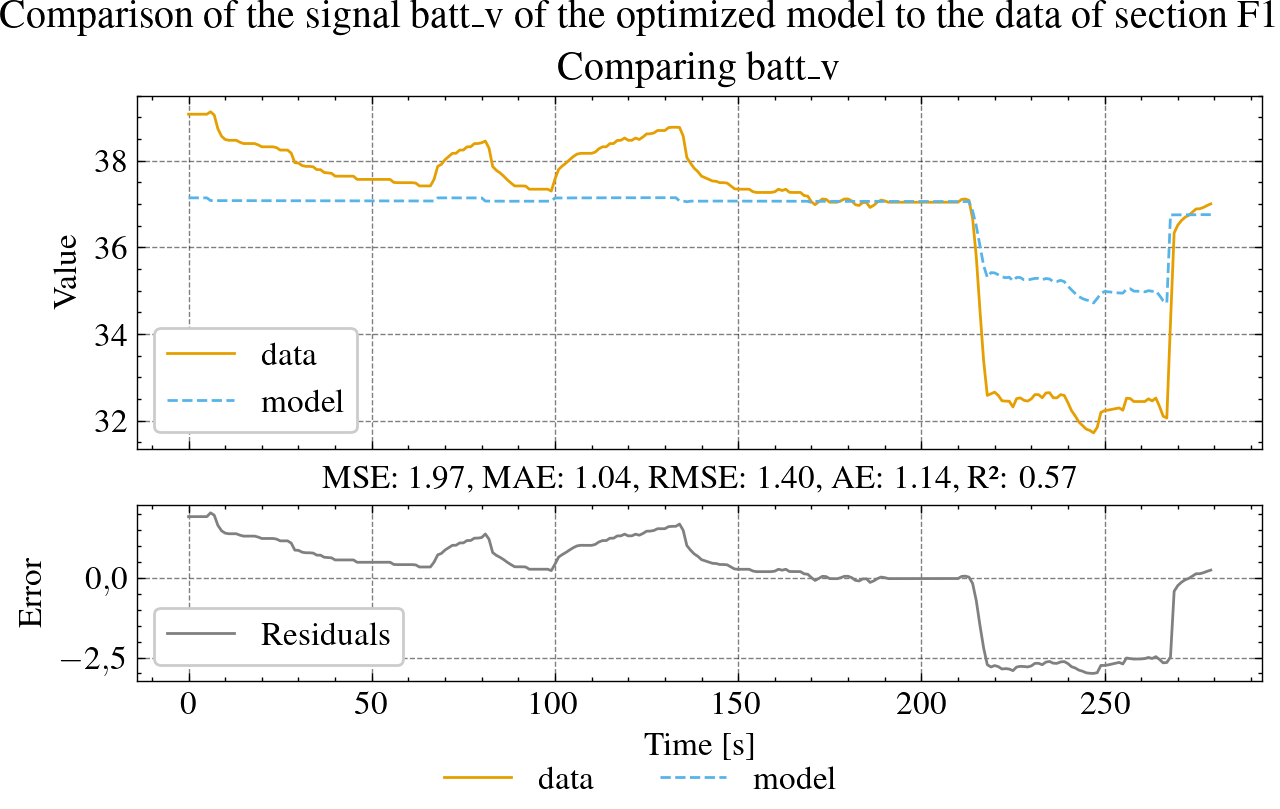

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f2.pdf


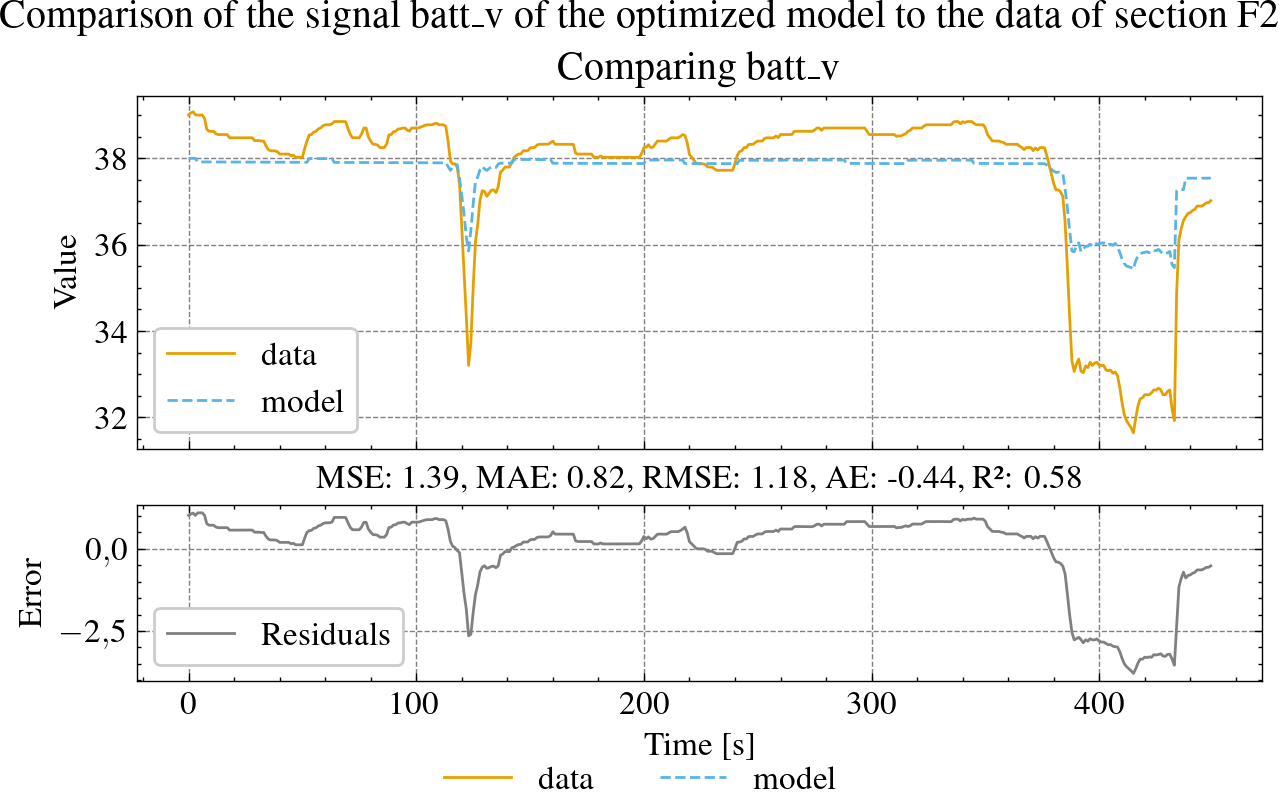

In [162]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)
    batt_z_0 = df_test['batt_z'][0]

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )
